In [1]:
from MLimports2 import *
exec(MLimports())


from copy import copy
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from lightgbm import LGBMClassifier as LGB
from scipy import stats
from sklearn import metrics,neighbors,preprocessing
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression as LR
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.me

In [2]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true[np.nonzero(y_true)] # avoid incidents with zero duration
    y_pred = y_pred[np.nonzero(y_true)]
    return abs(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

def smape(A, F):
    return 100/len(A) * np.sum( np.abs(F - A) / ((np.abs(A) + np.abs(F))/2.0) )

#second implementation
# def smape(A, F):
#     A = np.abs(np.mean(A)-F)
#     B = np.abs(np.mean(A)) + np.abs(F)
#     return 100.0*np.sum(A/B)/len(A)

from scipy import stats
def r2abs(yt,yp):
    A = np.sum(np.power(yp - yt, 2))
    B = np.sum(np.power(yt - np.mean(yt), 2))
    return abs(1-A/B)

def r2opt(yt,yp):
    A = np.sum(np.power(yp - yt, 2))
    B = np.sum(np.power(yt - np.mean(yt), 2))
    return A/B

def r2(yt,yp):
    A = np.sum(np.power(yp - yt, 2))
    B = np.sum(np.power(yt - np.mean(yt), 2))
    return 1-A/B

def mse(yt,yp):
    return mean_squared_error(yt,yp)

def rmse(yt,yp):
    return np.sqrt(mean_squared_error(yt,yp))


#
def csmape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true[np.nonzero(y_true)] # avoid incidents with zero duration
    y_pred = y_pred[np.nonzero(y_true)]
    CS = (np.abs(y_true - y_pred) > (y_true/6))
    y_pred[CS] -= y_true[CS]/6
    y_pred[~CS] = 0 
    return np.mean(CS*np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
X,Y = getBFS(part=[5,-1],dataset='a')

In [4]:
RESULTS = []

In [16]:
METRIC = []
from scipy.stats import wasserstein_distance as WD

def logWD(yt,yp):
    return WD(np.log1p(yt),np.log1p(yp))
METRIC.append({'name':'RMSE','instance':rmse})
METRIC.append({'name':'MAPE','instance':mape})
METRIC.append({'name':'R2','instance':r2opt})
METRIC.append({'name':'SMAPE','instance':smape})
METRIC.append({'name':'logWD','instance':logWD})

# Eval

In [17]:
from scipy.stats import wasserstein_distance as WD
from sklearn.preprocessing import QuantileTransformer as QT

def EVAL2(REG,MET,setup='AlltoAll',TH=40,log=False,dataset='a',qtran=False):
    global RESULTS,X,Y
    from sklearn.model_selection import KFold
    import multiprocessing
    
    X, Y = getBFS(part=[5,-1],dataset=dataset)
#     Y = np.array(sorted(Y))
    dbt=pd.read_csv('sectionsvic.csv').loc[:,['id','nb_lanes','rd_type','length']].reset_index().drop('index',axis=1)
    X=X.merge(dbt,how='inner',left_on='SectionID',right_on='id')

    X_A = X[Y<TH]
    Y_A = Y[Y<TH]
    
    X_B = X[Y>=TH]
    Y_B = Y[Y>=TH]
    
#     X_A, Y_A = getBFS(part=[0,TH])
#     X_B, Y_B = getBFS(part=[TH,-1])
    
    
    search = RandomizedSearchCV(estimator = REG['instance'](),
                       param_distributions=REG['param'],
                       n_iter=250,
                       scoring=make_scorer(MET['instance'], greater_is_better=False),
                       n_jobs=multiprocessing.cpu_count(), ## MAR: used to be 1
                       cv = 10,
                       verbose = 1
                           )
    qt=None
    qY=None
    
    if log:
        search.fit(X,np.log1p(Y))
    elif qtran:
        qt = QT()
        search.fit(X, qt.fit_transform(Y.reshape(-1,1)).ravel() )
    else:
        search.fit(X, Y)
    
    
    
    
    
    
    
    FOLDS=10
    ATTEMPTS=1
    
    SCOREMSE=[]
    SCORER2=[]
    SCORER2ABS=[]
    SCORESMAPE=[]
    SCOREMAPE=[]
    SCORECSMAPE=[]
    SCOREWD=[]
    
    import tqdm
    
    
    if setup=='AlltoA':
        for A in range(ATTEMPTS):
            
            kf = KFold(n_splits=FOLDS,shuffle=True)
    
            if setup=='AlltoAll':
                kf.get_n_splits(X)

            if setup=='AtoB':
                kf.get_n_splits(X_A)

            if setup=='AtoA':
                kf.get_n_splits(X_A)

            if setup=='BtoA':
                print('split BtoA')
                kf.get_n_splits(X_B)

            if setup=='AlltoB':
                print('split AlltoB')
                kf.get_n_splits(X_B)

            if setup=='AlltoA':
                print('split AlltoA')
                kf.get_n_splits(X_A)
            
            for train_index, test_index in tqdm.tqdm(kf.split(X_A)):
                
                Xtr, Xte = pd.concat([X_B,X_A.iloc[train_index]], axis=0), X_A.iloc[test_index]
                Ytr, Yte = np.concatenate([np.array(Y_B), np.array(Y_A)[train_index]],axis=0), Y_A[test_index]
                reg = REG['instance'](**search.best_params_)
                if log:
                    reg.fit(Xtr,np.log1p(Ytr))
                elif qtran:
                    qt = QT()
                    reg.fit(Xtr, qt.fit_transform(Ytr.reshape(-1,1)).ravel())
                else:
                    reg.fit(Xtr, Ytr)
                    
                pred = reg.predict(Xte)
                
                if log:
                    pred = np.nan_to_num(np.expm1(pred),0) ###
                
                if qtran:
                    pred = qt.inverse_transform(pred.reshape(-1,1)).ravel()
                
                PRED = np.array(pred).ravel()
                SCOREMSE.append(mse(Yte, PRED))
                SCOREMAPE.append(mape(Yte, PRED))
                SCORER2.append(r2(Yte,PRED))
                SCORER2ABS.append(r2abs(Yte,PRED))
                SCORESMAPE.append(smape(Yte,PRED))
                SCORECSMAPE.append(csmape(Yte,PRED))
                SCOREWD.append(WD(Yte,PRED)) 
                
    if setup=='AlltoB':
        for A in range(ATTEMPTS):
            
            kf = KFold(n_splits=FOLDS,shuffle=True)
    
            if setup=='AlltoAll':
                kf.get_n_splits(X)

            if setup=='AtoB':
                kf.get_n_splits(X_A)

            if setup=='AtoA':
                kf.get_n_splits(X_A)

            if setup=='BtoA':
                print('split BtoA')
                kf.get_n_splits(X_B)

            if setup=='AlltoB':
                print('split AlltoB')
                kf.get_n_splits(X_B)

            if setup=='AlltoA':
                print('split AlltoA')
                kf.get_n_splits(X_A)
                
                
            for train_index, test_index in tqdm.tqdm(kf.split(X_B)):
                
                Xtr, Xte = pd.concat([X_A,X_B.iloc[train_index]], axis=0), X_B.iloc[test_index]
                Ytr, Yte = np.concatenate([np.array(Y_A), np.array(Y_B)[train_index]],axis=0), Y_B[test_index]
                reg = REG['instance'](**search.best_params_)
                if log:
                    reg.fit(Xtr,np.log1p(Ytr))
                elif qtran:
                    qt = QT()
                    reg.fit(Xtr, qt.fit_transform(Ytr.reshape(-1,1)).ravel())
                else:
                    reg.fit(Xtr, Ytr)
                    
                pred = reg.predict(Xte)
                
                if log:
                    pred = np.nan_to_num(np.expm1(pred),0) ###
                
                if qtran:
                    pred = qt.inverse_transform(pred.reshape(-1,1)).ravel()
                PRED = np.array(pred).ravel()
                SCOREMSE.append(mse(Yte, PRED))
                SCOREMAPE.append(mape(Yte, PRED))
                SCORER2.append(r2(Yte,PRED))
                SCORER2ABS.append(r2abs(Yte,PRED))
                SCORESMAPE.append(smape(Yte,PRED))
                SCORECSMAPE.append(csmape(Yte,PRED))
                SCOREWD.append(WD(Yte,PRED)) 
                
    if setup=='AtoA':
        for A in range(ATTEMPTS):
            
            kf = KFold(n_splits=FOLDS,shuffle=True)
    
            if setup=='AlltoAll':
                kf.get_n_splits(X)

            if setup=='AtoB':
                kf.get_n_splits(X_A)

            if setup=='AtoA':
                kf.get_n_splits(X_A)

            if setup=='BtoA':
                print('split BtoA')
                kf.get_n_splits(X_B)

            if setup=='AlltoB':
                print('split AlltoB')
                kf.get_n_splits(X_B)

            if setup=='AlltoA':
                print('split AlltoA')
                kf.get_n_splits(X_A)
                
            for train_index, test_index in tqdm.tqdm(kf.split(X_A)):
                Xtr, Xte = X_A.iloc[train_index], X_A.iloc[test_index]
                Ytr, Yte = Y_A[train_index], Y_A[test_index]
                reg = REG['instance'](**search.best_params_)
                if log:
                    reg.fit(Xtr,np.log1p(Ytr))
                elif qtran:
                    qt = QT()
                    reg.fit(Xtr, qt.fit_transform(Ytr.reshape(-1,1)).ravel())
                else:
                    reg.fit(Xtr, Ytr)
                    
                pred = reg.predict(Xte)
                
                if log:
                    pred = np.nan_to_num(np.expm1(pred),0) ###
                
                if qtran:
                    pred = qt.inverse_transform(pred.reshape(-1,1)).ravel()
                PRED = np.array(pred).ravel()
                SCOREMSE.append(mse(Yte, PRED))
                SCOREMAPE.append(mape(Yte, PRED))
                SCORER2.append(r2(Yte,PRED))
                SCORER2ABS.append(r2abs(Yte,PRED))
                SCORESMAPE.append(smape(Yte,PRED))
                SCORECSMAPE.append(csmape(Yte,PRED))
                SCOREWD.append(WD(Yte,PRED)) 
                
                
    if setup=='AtoB':
        for A in range(ATTEMPTS):
            
            kf = KFold(n_splits=FOLDS,shuffle=True)
    
            if setup=='AlltoAll':
                kf.get_n_splits(X)

            if setup=='AtoB':
                kf.get_n_splits(X_A)

            if setup=='AtoA':
                kf.get_n_splits(X_A)

            if setup=='BtoA':
                print('split BtoA')
                kf.get_n_splits(X_B)

            if setup=='AlltoB':
                print('split AlltoB')
                kf.get_n_splits(X_B)

            if setup=='AlltoA':
                print('split AlltoA')
                kf.get_n_splits(X_A)
            
            for train_index, test_index in tqdm.tqdm(kf.split(X_A)):
                Xtr, Xte = X_A.iloc[train_index], X_B
                Ytr, Yte = Y_A[train_index], Y_B
                reg = REG['instance'](**search.best_params_)
                if log:
                    reg.fit(Xtr,np.log1p(Ytr))
                elif qtran:
                    qt = QT()
                    reg.fit(Xtr, qt.fit_transform(Ytr.reshape(-1,1)).ravel())
                else:
                    reg.fit(Xtr, Ytr)
                    
                pred = reg.predict(Xte)
                
                if log:
                    pred = np.nan_to_num(np.expm1(pred),0) ###
                
                if qtran:
                    pred = qt.inverse_transform(pred.reshape(-1,1)).ravel()
                PRED = np.array(pred).ravel()
                SCOREMSE.append(mse(Yte, PRED))
                SCOREMAPE.append(mape(Yte, PRED))
                SCORER2.append(r2(Yte,PRED))
                SCORER2ABS.append(r2abs(Yte,PRED))
                SCORESMAPE.append(smape(Yte,PRED))
                SCORECSMAPE.append(csmape(Yte,PRED))
                SCOREWD.append(WD(Yte,PRED)) 
                
    if setup=='BtoA':
        print('folding BtoA')
        for A in range(ATTEMPTS):
            
            
            kf = KFold(n_splits=FOLDS,shuffle=True)
    
            if setup=='AlltoAll':
                kf.get_n_splits(X)

            if setup=='AtoB':
                kf.get_n_splits(X_A)

            if setup=='AtoA':
                kf.get_n_splits(X_A)

            if setup=='BtoA':
                print('split BtoA')
                kf.get_n_splits(X_B)

            if setup=='AlltoB':
                print('split AlltoB')
                kf.get_n_splits(X_B)

            if setup=='AlltoA':
                print('split AlltoA')
                kf.get_n_splits(X_A)
                
                
                
            for train_index, test_index in tqdm.tqdm(kf.split(X_B)):
                Xtr, Xte = X_B.iloc[train_index], X_A
                Ytr, Yte = Y_B[train_index], Y_A
                reg = REG['instance'](**search.best_params_)
                if log:
                    reg.fit(Xtr,np.log1p(Ytr))
                elif qtran:
                    qt = QT()
                    reg.fit(Xtr, qt.fit_transform(Ytr.reshape(-1,1)).ravel())
                else:
                    reg.fit(Xtr, Ytr)
                    
                pred = reg.predict(Xte)
                
                if log:
                    pred = np.nan_to_num(np.expm1(pred),0) ###
                
                if qtran:
                    pred = qt.inverse_transform(pred.reshape(-1,1)).ravel()
                PRED = np.array(pred).ravel()
                SCOREMSE.append(mse(Yte, PRED))
                SCOREMAPE.append(mape(Yte, PRED))
                SCORER2.append(r2(Yte,PRED))
                SCORER2ABS.append(r2abs(Yte,PRED))
                SCORESMAPE.append(smape(Yte,PRED))
                SCORECSMAPE.append(csmape(Yte,PRED))
                SCOREWD.append(WD(Yte,PRED)) 
    
    if setup=='BtoB':
        print('folding BtoB')
        for A in range(ATTEMPTS):
            
            
            kf = KFold(n_splits=FOLDS,shuffle=True)
    
            if setup=='AlltoAll':
                kf.get_n_splits(X)

            if setup=='AtoB':
                kf.get_n_splits(X_A)

            if setup=='AtoA':
                kf.get_n_splits(X_A)

            if setup=='BtoA':
                print('split BtoA')
                kf.get_n_splits(X_B)

                
            if setup=='BtoB':
                print('split BtoB')
                kf.get_n_splits(X_B)
                
            if setup=='AlltoB':
                print('split AlltoB')
                kf.get_n_splits(X_B)

            if setup=='AlltoA':
                print('split AlltoA')
                kf.get_n_splits(X_A)
                
                
                
            for train_index, test_index in tqdm.tqdm(kf.split(X_B)):
                Xtr, Xte = X_B.iloc[train_index], X_B.iloc[test_index]
                Ytr, Yte = Y_B[train_index], Y_B[test_index]
                reg = REG['instance'](**search.best_params_)
                if log:
                    reg.fit(Xtr,np.log1p(Ytr))
                elif qtran:
                    qt = QT()
                    reg.fit(Xtr, qt.fit_transform(Ytr.reshape(-1,1)).ravel())
                else:
                    reg.fit(Xtr, Ytr)
                    
                pred = reg.predict(Xte)
                
                if log:
                    pred = np.nan_to_num(np.expm1(pred),0) ###
                
                if qtran:
                    pred = qt.inverse_transform(pred.reshape(-1,1)).ravel()
                PRED = np.array(pred).ravel()
                SCOREMSE.append(mse(Yte, PRED))
                SCOREMAPE.append(mape(Yte, PRED))
                SCORER2.append(r2(Yte,PRED))
                SCORER2ABS.append(r2abs(Yte,PRED))
                SCORESMAPE.append(smape(Yte,PRED))
                SCORECSMAPE.append(csmape(Yte,PRED))
                SCOREWD.append(WD(Yte,PRED)) 
    
    if setup=='AlltoAll':
        for A in range(ATTEMPTS):
            
            kf = KFold(n_splits=FOLDS,shuffle=True)
    
            if setup=='AlltoAll':
                kf.get_n_splits(X)

            if setup=='AtoB':
                kf.get_n_splits(X_A)

            if setup=='AtoA':
                kf.get_n_splits(X_A)

            if setup=='BtoA':
                print('split BtoA')
                kf.get_n_splits(X_B)
            
            if setup=='BtoB':
                print('split BtoB')
                kf.get_n_splits(X_B)

            if setup=='AlltoB':
                print('split AlltoB')
                kf.get_n_splits(X_B)

            if setup=='AlltoA':
                print('split AlltoA')
                kf.get_n_splits(X_A)
                
                
                
            for train_index, test_index in tqdm.tqdm(kf.split(X)):
                Xtr, Xte = X.iloc[train_index], X.iloc[test_index]
                Ytr, Yte = Y[train_index], Y[test_index]
                
#                 Ytr=np.log1p(Ytr) ###
                reg = REG['instance'](**search.best_params_)
    
                if log:
                    reg.fit(Xtr,np.log1p(Ytr))
                elif qtran:
                    qt = QT()
                    reg.fit(Xtr, qt.fit_transform(Ytr.reshape(-1,1)).ravel())
                else:
                    reg.fit(Xtr, Ytr)
                    
                pred = reg.predict(Xte)
                
                if log:
                    pred = np.nan_to_num(np.expm1(pred),0) ###
                
                if qtran:
                    pred = qt.inverse_transform(pred.reshape(-1,1)).ravel()
                PRED = np.array(pred).ravel()
                SCOREMSE.append(mse(Yte, PRED))
                SCOREMAPE.append(mape(Yte, PRED))
                SCORER2.append(r2(Yte,PRED))
                SCORER2ABS.append(r2abs(Yte,PRED))
                SCORESMAPE.append(smape(Yte,PRED))
                SCORECSMAPE.append(csmape(Yte,PRED))
                SCOREWD.append(WD(Yte,PRED)) 

#     RESULTS.append({'Optimizer': REG['name'],
#       'Training': MET['name'],
#       'mape': np.array(SCOREMAPE).mean(),
#       'smape': np.array(SCORESMAPE).mean(), 'csmape': np.array(SCORECSMAPE).mean(),
#       'r2': np.array(SCORER2).mean(), 'r2abs': np.array(SCORER2ABS).mean(),
#       'mse': np.array(SCOREMSE).mean(),'folding':'KF'})
    
    for zz in range(len(SCOREMAPE)):
        RESULTS.append({'Optimizer': REG['name'],
          'Training': MET['name'],
          'mape': SCOREMAPE[zz],
          'smape': SCORESMAPE[zz], 'csmape': SCORECSMAPE[zz],
          'r2': SCORER2[zz], 'r2abs': SCORER2ABS[zz],
          'mse': SCOREMSE[zz],'WD':SCOREWD[zz],'folding':'KF'})



In [18]:
from sklearn.svm import SVR
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
OPTIMIZER = []

# OPTIMIZER.append({'name':'SVM','instance':SVR,'param':{
#             'C':np.linspace(0.01,100,100),
#             'kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
#             'epsilon':np.linspace(0.01,100,100)
#         }})
from sklearn import linear_model
# reg=linear_model.BayesianRidge(alpha_1=10,alpha_2=1e-3,lambda_1=1e-3,lambda_2=1e-2
                               
                

OPTIMIZER.append({'name':'XGB','instance':XGBRegressor,'param':{
            'learning_rate' : np.linspace(0.0001,0.9999,10000), 
            'n_estimators' : range(20,200,1),'objective':['reg:squarederror','reg:gamma', 'reg:tweedie'],
            'max_depth':range(2,15,1), ##MAR: start at 3 
            'subsample':np.linspace(0.3, 0.9 ,10000),'colsample_bytree': np.linspace(0.1,0.9,10000),
            'min_child_weight':np.arange(2,15),
#             'gamma':np.arange(0.01,5),
#             'reg_alpha':np.arange(0,5),'reg_lambda':np.arange(0,5)
        }})

OPTIMIZER.append({'name':'LGBM','instance':lgb.LGBMRegressor,'param':{
            'feature_fraction':np.linspace(0.5,1,100),'bagging_fraction':np.linspace(0.5,1,100),
            'learning_rate' : np.linspace(0.00001,1,10000), 'lambda_l1':np.linspace(0,5,1000),'lambda_l2':np.linspace(0,5,1000),
            'max_depth' : np.arange(2,15), 'metric':['MAE','RMSE'],'objective':['huber', 'gamma', 'fair', 'tweedie'],
        }})

OPTIMIZER.append({'name':'KNN','instance':KNeighborsRegressor,'param':{
            'n_neighbors' : range(2,100), 
            'weights' : ['uniform','distance'],
            'p':[1,2], 'leaf_size': np.arange(2,60)
        }})

# OPTIMIZER.append({'name':'CB','instance':CatBoostRegressor,'param':{
#             'learning_rate' : np.linspace(0.0001,1,10000),'n_estimators':np.arange(20,200),
#             'depth' : np.arange(2,9), 'verbose': [0], 'l2_leaf_reg': np.linspace(0,5,1000), 'eval_metric':['MAE', 'RMSE', 'Poisson'],
# #             'p':[1,2], 'leaf_size': np.arange(2,60)
#         }})

# OPTIMIZER.append({'name':'NGB','instance': NGBRegressor, 'param':{
#     'learning_rate' : np.linspace(0.0001,1,10000),
# #     'minibatch_frac' : np.linspace(0.001,1,1000), 
#     'n_estimators' : range(20,250,1),
# #     'max_depth':range(2,15,1), ##MAR: start at 3 
# #     'subsample':np.linspace(0.25, 1.0 ,10000), 'min_samples_split':np.linspace(0.001,0.999,1000)
# }})

OPTIMIZER.append({'name':'GBDT','instance': GradientBoostingRegressor, 'param':{
    'learning_rate' : np.linspace(0.00001,1,10000), 
    'n_estimators' : range(20,200,1),
    'max_depth':range(2,15,1), ##MAR: start at 3 
    'subsample':np.linspace(0.25, 1.0 ,10000), 'min_samples_split':np.linspace(0.001,0.999,1000)
}})

OPTIMIZER.append({'name':'LR','instance': Ridge, 'param':{
    'alpha':np.linspace(0,10,10000), 'normalize': [True,False], 'fit_intercept':[True,False]
}})

OPTIMIZER.append({'name':'BR','instance':linear_model.BayesianRidge,'param':{
            'alpha_1':np.linspace(1e-6,1,10000),
            'alpha_2':np.linspace(1e-6,1,10000),
            'lambda_1':np.linspace(1e-6,1,10000),
            'lambda_2':np.linspace(1e-6,1,10000),
        }})               

OPTIMIZER.append({'name':'RF','instance': RandomForestRegressor, 'param':{
    'n_estimators' : range(20,200,1),
    'max_depth':range(2,15,1), ##MAR: start at 3 
}})

In [19]:
experiment='AtoA'
RESULTS = []
import tqdm
for O in tqdm.tqdm(OPTIMIZER):
    print(O['name'])
    for M in METRIC:
        print(M['name'])
        print('lpo')
        EVAL2(O,M,setup=experiment,dataset='a',TH=45,log=False,qtran=False)
#         EVAL_LOOCV(O,M)
        print('kfold')

  0%|          | 0/7 [00:00<?, ?it/s]

XGB
RMSE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:   12.9s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:   13.6s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:   14.9s
[Parallel(n_jobs=56)]: Done 1138 tasks      | elapsed:   16.3s
[Parallel(n_jobs=56)]: Done 1688 tasks      | elapsed:   17.9s
[Parallel(n_jobs=56)]: Done 2338 tasks      | elapsed:   19.9s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:   20.4s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
2it [00:00, 16.24it/s]
5it [00:00, 17.75it/s]
7it [00:00, 14.57it/s]
10it [00:00, 13.51it/s][A
[Parallel(n_jobs=56)]: Using backend LokyBackend

kfold
MAPE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    1.2s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:    2.2s
[Parallel(n_jobs=56)]: Done 1138 tasks      | elapsed:    3.6s
[Parallel(n_jobs=56)]: Done 1688 tasks      | elapsed:    5.3s
[Parallel(n_jobs=56)]: Done 2338 tasks      | elapsed:    7.1s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    7.6s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
3it [00:00, 28.55it/s]
10it [00:00, 37.87it/s][A
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
R2
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  91 tasks      | elapsed:    0.5s
[Parallel(n_jobs=56)]: Done 576 tasks      | elapsed:    1.5s
[Parallel(n_jobs=56)]: Done 1276 tasks      | elapsed:    2.8s
[Parallel(n_jobs=56)]: Done 2176 tasks      | elapsed:    4.7s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    5.5s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
1it [00:00,  9.67it/s]
3it [00:00,  8.38it/s]
4it [00:00,  6.93it/s]
5it [00:00,  7.30it/s]
8it [00:00,  9.32it/s]
10it [00:01,  9.04it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
SMAPE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done 160 tasks      | elapsed:    0.7s
[Parallel(n_jobs=56)]: Done 1160 tasks      | elapsed:    2.3s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    5.0s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
2it [00:00, 13.32it/s]
4it [00:00, 14.59it/s]
5it [00:00, 12.25it/s]
7it [00:00, 13.47it/s]
9it [00:00,  8.72it/s]
10it [00:01,  9.85it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
logWD
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    1.5s
[Parallel(n_jobs=56)]: Done 1264 tasks      | elapsed:    3.0s
[Parallel(n_jobs=56)]: Done 2164 tasks      | elapsed:    4.6s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    5.5s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
1it [00:00,  7.00it/s]
2it [00:00,  7.08it/s]
3it [00:00,  6.77it/s]
4it [00:00,  6.93it/s]
6it [00:00,  7.86it/s]
7it [00:00,  8.33it/s]
8it [00:01,  6.34it/s]
9it [00:01,  6.14it/s]
10it [00:01,  6.98it/s]
 14%|█▍        | 1/7 [00:49<04:56, 49.34s/it][Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
LGBM
RMSE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    1.2s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:    2.1s
[Parallel(n_jobs=56)]: Done 1138 tasks      | elapsed:    3.3s
[Parallel(n_jobs=56)]: Done 1688 tasks      | elapsed:    4.7s
[Parallel(n_jobs=56)]: Done 2338 tasks      | elapsed:    6.4s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    6.8s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
2it [00:00, 17.71it/s]

[LightGBM] [Warning] lambda_l1 is set=0.8858858858858859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8858858858858859
[LightGBM] [Warning] feature_fraction is set=0.8585858585858586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8585858585858586
[LightGBM] [Warning] lambda_l2 is set=1.916916916916917, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.916916916916917
[LightGBM] [Warning] bagging_fraction is set=0.8838383838383839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838383838383839
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l1 is set=0.8858858858858859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8858858858858859
[LightGBM] [Warning] feature_fraction is set=0.8585858585858586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8585858585858586
[LightGBM] [Warni


4it [00:00, 17.16it/s]

[LightGBM] [Warning] lambda_l1 is set=0.8858858858858859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8858858858858859
[LightGBM] [Warning] feature_fraction is set=0.8585858585858586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8585858585858586
[LightGBM] [Warning] lambda_l2 is set=1.916916916916917, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.916916916916917
[LightGBM] [Warning] bagging_fraction is set=0.8838383838383839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838383838383839
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l1 is set=0.8858858858858859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8858858858858859
[LightGBM] [Warning] feature_fraction is set=0.8585858585858586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8585858585858586
[LightGBM] [Warni


6it [00:00, 15.09it/s]
8it [00:00, 15.70it/s]

[LightGBM] [Warning] lambda_l1 is set=0.8858858858858859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8858858858858859
[LightGBM] [Warning] feature_fraction is set=0.8585858585858586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8585858585858586
[LightGBM] [Warning] lambda_l2 is set=1.916916916916917, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.916916916916917
[LightGBM] [Warning] bagging_fraction is set=0.8838383838383839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838383838383839
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l1 is set=0.8858858858858859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8858858858858859
[LightGBM] [Warning] feature_fraction is set=0.8585858585858586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8585858585858586
[LightGBM] [Warni


10it [00:00, 15.66it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
MAPE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 1016 tasks      | elapsed:    2.0s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    4.1s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
3it [00:00, 28.00it/s]

[LightGBM] [Warning] lambda_l1 is set=3.813813813813814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.813813813813814
[LightGBM] [Warning] feature_fraction is set=0.6414141414141414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6414141414141414
[LightGBM] [Warning] lambda_l2 is set=4.1541541541541545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1541541541541545
[LightGBM] [Warning] bagging_fraction is set=0.6313131313131313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6313131313131313
[LightGBM] [Warning] lambda_l1 is set=3.813813813813814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.813813813813814
[LightGBM] [Warning] feature_fraction is set=0.6414141414141414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6414141414141414
[LightGBM] [Warning] lambda_l2 is set=4.1541541541541545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1541541541541545
[LightGBM] [War


5it [00:00, 19.33it/s]
6it [00:00, 13.88it/s]

[LightGBM] [Warning] lambda_l1 is set=3.813813813813814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.813813813813814
[LightGBM] [Warning] feature_fraction is set=0.6414141414141414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6414141414141414
[LightGBM] [Warning] lambda_l2 is set=4.1541541541541545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1541541541541545
[LightGBM] [Warning] bagging_fraction is set=0.6313131313131313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6313131313131313
[LightGBM] [Warning] lambda_l1 is set=3.813813813813814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.813813813813814
[LightGBM] [Warning] feature_fraction is set=0.6414141414141414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6414141414141414
[LightGBM] [Warning] lambda_l2 is set=4.1541541541541545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1541541541541545
[LightGBM] [War


8it [00:00, 14.78it/s]
10it [00:00, 15.72it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


[LightGBM] [Warning] lambda_l1 is set=3.813813813813814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.813813813813814
[LightGBM] [Warning] feature_fraction is set=0.6414141414141414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6414141414141414
[LightGBM] [Warning] lambda_l2 is set=4.1541541541541545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1541541541541545
[LightGBM] [Warning] bagging_fraction is set=0.6313131313131313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6313131313131313
[LightGBM] [Warning] lambda_l1 is set=3.813813813813814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.813813813813814
[LightGBM] [Warning] feature_fraction is set=0.6414141414141414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6414141414141414
[LightGBM] [Warning] lambda_l2 is set=4.1541541541541545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1541541541541545
[LightGBM] [War

[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 1468 tasks      | elapsed:    2.7s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    4.1s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[LightGBM] [Warning] lambda_l1 is set=0.23523523523523523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23523523523523523
[LightGBM] [Warning] feature_fraction is set=0.595959595959596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.595959595959596
[LightGBM] [Warning] lambda_l2 is set=0.8408408408408409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8408408408408409
[LightGBM] [Warning] bagging_fraction is set=0.5656565656565656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5656565656565656
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).



0it [00:00, ?it/s]
2it [00:00, 17.80it/s]
4it [00:00, 17.66it/s]

[LightGBM] [Warning] lambda_l1 is set=0.23523523523523523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23523523523523523
[LightGBM] [Warning] feature_fraction is set=0.595959595959596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.595959595959596
[LightGBM] [Warning] lambda_l2 is set=0.8408408408408409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8408408408408409
[LightGBM] [Warning] bagging_fraction is set=0.5656565656565656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5656565656565656
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l1 is set=0.23523523523523523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23523523523523523
[LightGBM] [Warning] feature_fraction is set=0.595959595959596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.595959595959596
[LightGBM] [War


6it [00:00, 17.35it/s]

[LightGBM] [Warning] lambda_l1 is set=0.23523523523523523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23523523523523523
[LightGBM] [Warning] feature_fraction is set=0.595959595959596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.595959595959596
[LightGBM] [Warning] lambda_l2 is set=0.8408408408408409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8408408408408409
[LightGBM] [Warning] bagging_fraction is set=0.5656565656565656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5656565656565656
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l1 is set=0.23523523523523523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23523523523523523
[LightGBM] [Warning] feature_fraction is set=0.595959595959596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.595959595959596
[LightGBM] [War


8it [00:00, 13.81it/s]
10it [00:00, 14.81it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


[LightGBM] [Warning] lambda_l1 is set=0.23523523523523523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23523523523523523
[LightGBM] [Warning] feature_fraction is set=0.595959595959596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.595959595959596
[LightGBM] [Warning] lambda_l2 is set=0.8408408408408409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8408408408408409
[LightGBM] [Warning] bagging_fraction is set=0.5656565656565656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5656565656565656
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l1 is set=0.23523523523523523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23523523523523523
[LightGBM] [Warning] feature_fraction is set=0.595959595959596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.595959595959596
[LightGBM] [War

[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 1016 tasks      | elapsed:    2.0s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    4.1s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
2it [00:00, 17.81it/s]

[LightGBM] [Warning] lambda_l1 is set=0.3103103103103103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3103103103103103
[LightGBM] [Warning] feature_fraction is set=0.5404040404040404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5404040404040404
[LightGBM] [Warning] lambda_l2 is set=1.0610610610610611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0610610610610611
[LightGBM] [Warning] bagging_fraction is set=0.8737373737373737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737373737373737
[LightGBM] [Warning] lambda_l1 is set=0.3103103103103103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3103103103103103
[LightGBM] [Warning] feature_fraction is set=0.5404040404040404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5404040404040404
[LightGBM] [Warning] lambda_l2 is set=1.0610610610610611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0610610610610611
[LightGBM] 


5it [00:00, 19.15it/s]
8it [00:00, 20.15it/s]

[LightGBM] [Warning] lambda_l1 is set=0.3103103103103103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3103103103103103
[LightGBM] [Warning] feature_fraction is set=0.5404040404040404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5404040404040404
[LightGBM] [Warning] lambda_l2 is set=1.0610610610610611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0610610610610611
[LightGBM] [Warning] bagging_fraction is set=0.8737373737373737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737373737373737
[LightGBM] [Warning] lambda_l1 is set=0.3103103103103103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3103103103103103
[LightGBM] [Warning] feature_fraction is set=0.5404040404040404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5404040404040404
[LightGBM] [Warning] lambda_l2 is set=1.0610610610610611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0610610610610611
[LightGBM] 

10it [00:00, 23.21it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
logWD
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 1016 tasks      | elapsed:    2.0s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    4.1s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[LightGBM] [Warning] lambda_l1 is set=0.8358358358358359, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8358358358358359
[LightGBM] [Warning] feature_fraction is set=0.9242424242424243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9242424242424243
[LightGBM] [Warning] lambda_l2 is set=4.2992992992992995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2992992992992995
[LightGBM] [Warning] bagging_fraction is set=0.9494949494949496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9494949494949496
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).



0it [00:00, ?it/s]
1it [00:00,  9.18it/s]
2it [00:00,  8.79it/s]

[LightGBM] [Warning] lambda_l1 is set=0.8358358358358359, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8358358358358359
[LightGBM] [Warning] feature_fraction is set=0.9242424242424243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9242424242424243
[LightGBM] [Warning] lambda_l2 is set=4.2992992992992995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2992992992992995
[LightGBM] [Warning] bagging_fraction is set=0.9494949494949496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9494949494949496
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l1 is set=0.8358358358358359, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8358358358358359
[LightGBM] [Warning] feature_fraction is set=0.9242424242424243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9242424242424243
[LightGBM] [War


3it [00:00,  8.70it/s]
4it [00:00,  9.03it/s]


[LightGBM] [Warning] lambda_l1 is set=0.8358358358358359, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8358358358358359
[LightGBM] [Warning] feature_fraction is set=0.9242424242424243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9242424242424243
[LightGBM] [Warning] lambda_l2 is set=4.2992992992992995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2992992992992995
[LightGBM] [Warning] bagging_fraction is set=0.9494949494949496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9494949494949496
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l1 is set=0.8358358358358359, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8358358358358359
[LightGBM] [Warning] feature_fraction is set=0.9242424242424243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9242424242424243
[LightGBM] [War

6it [00:00, 10.63it/s]
8it [00:00, 12.20it/s]

[LightGBM] [Warning] lambda_l1 is set=0.8358358358358359, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8358358358358359
[LightGBM] [Warning] feature_fraction is set=0.9242424242424243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9242424242424243
[LightGBM] [Warning] lambda_l2 is set=4.2992992992992995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2992992992992995
[LightGBM] [Warning] bagging_fraction is set=0.9494949494949496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9494949494949496
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l1 is set=0.8358358358358359, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8358358358358359
[LightGBM] [Warning] feature_fraction is set=0.9242424242424243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9242424242424243
[LightGBM] [War


10it [00:00, 12.68it/s]
 29%|██▊       | 2/7 [01:16<03:33, 42.69s/it][Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
KNN
RMSE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 415 tasks      | elapsed:    0.9s
[Parallel(n_jobs=56)]: Done 1115 tasks      | elapsed:    1.8s
[Parallel(n_jobs=56)]: Done 2015 tasks      | elapsed:    2.8s
[Parallel(n_jobs=56)]: Done 2389 out of 2500 | elapsed:    3.2s remaining:    0.2s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    3.3s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

10it [00:00, 269.81it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
MAPE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.3s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    0.9s
[Parallel(n_jobs=56)]: Done 1264 tasks      | elapsed:    1.8s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    2.8s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

10it [00:00, 355.19it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
R2
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.3s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    1.1s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

10it [00:00, 342.53it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
SMAPE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.3s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    1.1s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

10it [00:00, 354.26it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
logWD
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.3s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    1.1s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

10it [00:00, 399.49it/s]
 43%|████▎     | 3/7 [01:26<02:11, 32.80s/it][Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
GBDT
RMSE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.3s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    1.3s
[Parallel(n_jobs=56)]: Done 1264 tasks      | elapsed:    2.5s
[Parallel(n_jobs=56)]: Done 2164 tasks      | elapsed:    4.4s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    5.2s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
4it [00:00, 30.51it/s]
10it [00:00, 30.49it/s][A
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
MAPE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    5.2s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
4it [00:00, 35.24it/s]
10it [00:00, 34.40it/s][A
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
R2
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.3s
[Parallel(n_jobs=56)]: Done 1468 tasks      | elapsed:    2.7s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    6.0s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
5it [00:00, 42.44it/s]
10it [00:00, 42.18it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
SMAPE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 1016 tasks      | elapsed:    2.0s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    4.7s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
3it [00:00, 24.50it/s]
6it [00:00, 24.66it/s]
10it [00:00, 25.05it/s][A
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
logWD
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 1016 tasks      | elapsed:    2.0s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    4.5s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
2it [00:00, 12.50it/s]
4it [00:00, 12.53it/s]
6it [00:00, 12.59it/s]
8it [00:00, 12.64it/s]
10it [00:00, 12.51it/s]
 57%|█████▋    | 4/7 [01:54<01:34, 31.38s/it][Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
LR
RMSE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.3s
[Parallel(n_jobs=56)]: Done 1016 tasks      | elapsed:    0.9s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    1.9s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

10it [00:00, 293.26it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
MAPE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    1.1s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

10it [00:00, 316.61it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
R2
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    1.1s finished

10it [00:00, 287.23it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
SMAPE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    1.1s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

10it [00:00, 291.80it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
logWD
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    1.2s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.08973e-16): result may not be accurate.
  overwrite_a=True).T

10it [00:00, 352.74it/s]
 71%|███████▏  | 5/7 [02:01<00:47, 23.99s/it][Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
BR
RMSE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    1.4s finished

10it [00:00, 219.74it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  16 tasks      | elapsed:    0.1s


kfold
MAPE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    0.9s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

10it [00:00, 146.60it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
R2
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    1.3s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

10it [00:00, 250.24it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
SMAPE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    1.4s finished

10it [00:00, 250.32it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
logWD
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:    1.2s finished

10it [00:00, 264.84it/s]
 86%|████████▌ | 6/7 [02:07<00:18, 18.80s/it][Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
RF
RMSE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.7s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    2.1s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:    4.1s
[Parallel(n_jobs=56)]: Done 1138 tasks      | elapsed:    7.1s
[Parallel(n_jobs=56)]: Done 1688 tasks      | elapsed:   10.8s
[Parallel(n_jobs=56)]: Done 2338 tasks      | elapsed:   15.0s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:   16.4s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
3it [00:00, 25.96it/s]
6it [00:00, 26.19it/s]
10it [00:00, 26.41it/s][A
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
MAPE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.7s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    2.3s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:    4.4s
[Parallel(n_jobs=56)]: Done 1138 tasks      | elapsed:    7.6s
[Parallel(n_jobs=56)]: Done 1688 tasks      | elapsed:   11.9s
[Parallel(n_jobs=56)]: Done 2338 tasks      | elapsed:   16.4s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:   17.4s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
2it [00:00, 11.29it/s]
4it [00:00, 11.38it/s]
6it [00:00, 11.44it/s]
8it [00:00, 11.56it/s]
10it [00:00, 11.64it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
R2
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  93 tasks      | elapsed:    0.7s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    3.3s
[Parallel(n_jobs=56)]: Done 1263 tasks      | elapsed:    8.0s
[Parallel(n_jobs=56)]: Done 1722 tasks      | elapsed:   11.2s
[Parallel(n_jobs=56)]: Done 2272 tasks      | elapsed:   14.6s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:   16.5s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
1it [00:00,  6.24it/s]
2it [00:00,  6.25it/s]
3it [00:00,  6.28it/s]
4it [00:00,  6.29it/s]
5it [00:00,  6.34it/s]
6it [00:00,  6.36it/s]
7it [00:01,  6.35it/s]
8it [00:01,  6.34it/s]
9it [00:01,  6.35it/s]
10it [00:01,  6.35it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend wi

kfold
SMAPE
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.7s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    2.5s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:    5.3s
[Parallel(n_jobs=56)]: Done 1138 tasks      | elapsed:    8.3s
[Parallel(n_jobs=56)]: Done 1688 tasks      | elapsed:   11.7s
[Parallel(n_jobs=56)]: Done 2338 tasks      | elapsed:   15.7s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:   16.9s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
1it [00:00,  7.74it/s]
2it [00:00,  7.87it/s]
3it [00:00,  7.91it/s]
4it [00:00,  7.86it/s]
5it [00:00,  7.83it/s]
6it [00:00,  7.91it/s]
7it [00:00,  7.84it/s]
8it [00:01,  7.76it/s]
9it [00:01,  7.76it/s]
10it [00:01, 

kfold
logWD
lpo
Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.9s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    3.8s
[Parallel(n_jobs=56)]: Done 1020 tasks      | elapsed:    6.7s
[Parallel(n_jobs=56)]: Done 1470 tasks      | elapsed:    9.4s
[Parallel(n_jobs=56)]: Done 2020 tasks      | elapsed:   12.7s
[Parallel(n_jobs=56)]: Done 2500 out of 2500 | elapsed:   15.9s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

0it [00:00, ?it/s]
2it [00:00, 18.10it/s]
4it [00:00, 18.21it/s]
6it [00:00, 18.15it/s]
8it [00:00, 18.18it/s]
10it [00:00, 18.23it/s]
100%|██████████| 7/7 [03:36<00:00, 30.90s/it]

kfold


In [20]:
RESULTS
RES = pd.DataFrame(RESULTS)
RES

,Optimizer,Training,mape,smape,csmape,r2,r2abs,mse,WD,folding
0,XGB,RMSE,65.257056,46.831741,63.611916,-0.045706,0.045706,140.452420,6.160600,KF
1,XGB,RMSE,52.956125,38.097111,47.899022,-0.022714,0.022714,98.325785,5.161770,KF
2,XGB,RMSE,72.759959,48.919465,71.457445,-0.204415,0.204415,159.873529,6.903147,KF
3,XGB,RMSE,90.419278,59.202514,88.601153,-0.412441,0.412441,218.738070,6.934836,KF
4,XGB,RMSE,54.548364,41.717375,51.096861,0.005795,0.005795,97.675589,5.699479,KF
...,...,...,...,...,...,...,...,...,...,...
345,RF,logWD,85.060817,51.049506,83.294951,-0.149792,0.149792,145.187343,6.996993,KF
346,RF,logWD,66.615789,42.844265,61.745165,0.074288,0.074288,114.912266,7.098569,KF
347,RF,logWD,50.977088,39.572994,49.685731,0.024723,0.024723,115.159094,6.360667,KF
348,RF,logWD,64.249472,41.374748,62.515225,-0.085491,0.085491,113.218974,6.281806,KF


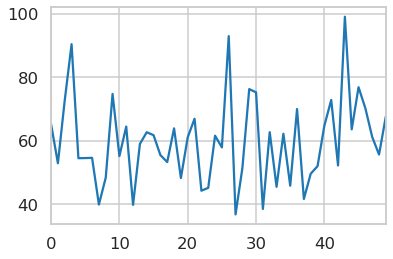

In [21]:
RES = pd.DataFrame(RESULTS)
RES[RES.Optimizer=='XGB'].mape.plot()
# RES[RES.Optimizer=='XGB'].csmape.plot()
# RES[RES.Optimizer=='LGBM'].mape.plot()

In [22]:
RES[RES.Training=='mape']

,Optimizer,Training,mape,smape,csmape,r2,r2abs,mse,WD,folding


In [23]:
RES['rmse'] = RES['mse'].apply(lambda v: np.sqrt(v))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

ValueError: Could not interpret input 'logWD'

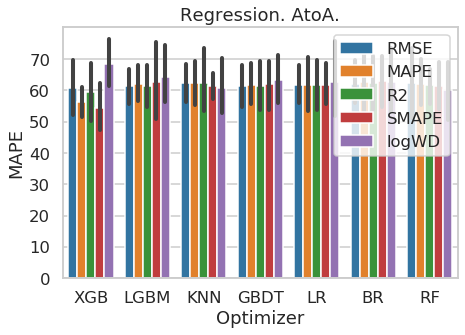

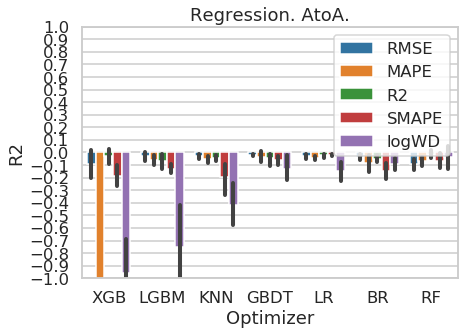

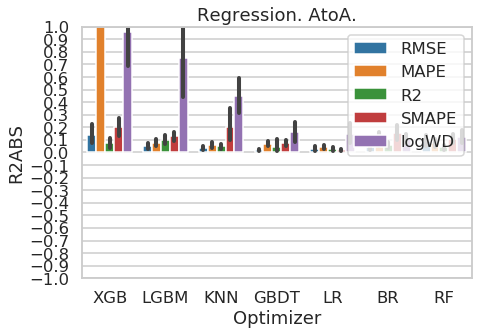

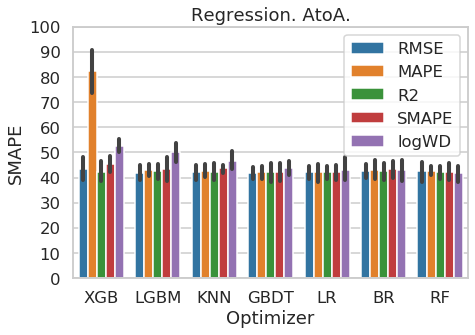

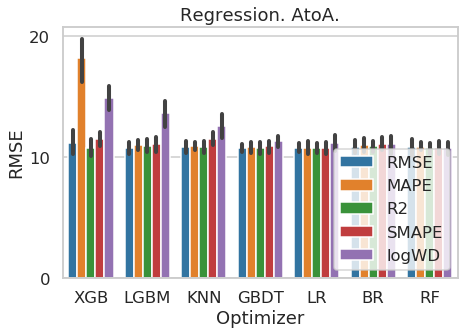

<Figure size 489.6x360 with 0 Axes>

In [24]:
for f in ['KF']:
    for M in ['mape','r2','r2abs','smape','rmse','logWD']:
#         print(M)
        import seaborn as sns
        sns.set_style("ticks")
        sns.set_style("whitegrid")
        sns.set_context("talk")

        plt.figure(figsize=(6.8,5))
        ax = sns.barplot(x="Optimizer", y=M,hue='Training', data=RES[RES.folding==f])
        plt.setp(ax.get_legend().get_texts(), fontsize='13')

        plt.title('Regression. {}.'.format(experiment))
        plt.tight_layout()
        plt.ylabel(M.upper())

        if M=='r2' or M=='r2abs':
            plt.ylim(0,1)
            plt.yticks(np.arange(-1,1.1,0.1))

        elif M=='mape' or M=='csmape' or M=='rmse':
            plt.yticks(np.round(np.arange(0,RES[RES.folding==f][M].mean()+10,10)))
        else:
            plt.yticks(np.round(np.arange(0,RES[RES.folding==f][M].max()+5,10)))

        if M=='rmse':
            plt.legend(loc='lower right')
        else:
            plt.legend(loc='upper right')
    #     plt.show()
        plt.savefig('Xregression_{}_var_{}_{}.eps'.format(experiment,M,f),format='eps')
        plt.savefig('Xregression_{}_var_{}_{}.png'.format(experiment,M,f),format='png')

In [25]:
import os
os.system("tar -cf sf{}.tar Xregression_{}*".format(experiment,experiment))

0

In [15]:
RES

,Optimizer,Training,mape,smape,csmape,r2,r2abs,mse,WD,folding,rmse
0,XGB,RMSE,48.005754,38.198055,45.831212,0.022905,0.022905,108.065910,6.687293,KF,10.395475
1,XGB,RMSE,43.786497,41.812447,46.564359,-0.287693,0.287693,129.158268,6.863756,KF,11.364782
2,XGB,RMSE,76.042093,50.830999,71.873098,-0.099830,0.099830,119.595109,6.840799,KF,10.935955
3,XGB,RMSE,65.796788,43.380491,60.814908,-0.073350,0.073350,118.743169,6.456952,KF,10.896934
4,XGB,RMSE,55.561911,48.830904,59.019614,-0.582249,0.582249,184.698150,8.881599,KF,13.590370
...,...,...,...,...,...,...,...,...,...,...,...
345,RF,WD,71.583880,49.554694,70.021350,-0.091702,0.091702,160.497185,7.439378,KF,12.668748
346,RF,WD,77.862146,51.019404,76.511207,-0.191138,0.191138,167.290240,6.587715,KF,12.934073
347,RF,WD,66.509851,44.586340,61.899752,-0.097491,0.097491,124.223460,6.484554,KF,11.145558
348,RF,WD,41.738348,33.361562,35.949190,-0.039343,0.039343,95.784166,5.367899,KF,9.786939


In [48]:
# import multiprocessing
# search = RandomizedSearchCV(estimator = XGBRegressor(),
#                                param_distributions={
#             'learning_rate' : [0.0001, 0.001, 0.1,0.01], 
#             'n_estimators' : range(20,200,1),
#             'max_depth':range(1,15,1), ##MAR: start at 3 
#             'subsample':[0.6,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
#         },
#                                n_iter=100,
#                                scoring=make_scorer(smape, greater_is_better=False),
#                                n_jobs=multiprocessing.cpu_count(), ## MAR: used to be 1
#                                cv = 5,
#                                verbose = 1
#                                 )
# search.fit(X,Y)

In [49]:
# XGBRegressor(**search.best_params_)

In [50]:




# from sklearn.model_selection import cross_val_score

# cross_val_score(reg, X, Y, cv=kf)

In [51]:
# from sklearn.model_selection import KFold
# from sklearn.model_selection import LeaveOneOut
# kf = LeaveOneOut()
# kf.get_n_splits(X)

# PREDS=[]

# for train_index, test_index in kf.split(X):
#     Xtr, Xte = X.iloc[train_index], X.iloc[test_index]
#     Ytr, Yte = Y[train_index], Y[test_index]
#     print(test_index)
#     reg = XGBRegressor(learning_rate=0.0001, max_depth=9, n_estimators=20, subsample=0.95)
#     reg.fit(Xtr, Ytr)
#     PREDS.append(reg.predict(Xte))
    
    
    

In [52]:
# PREDS

In [53]:
# mape(np.array(PREDS).ravel(),Y)

In [2]:
def CHECK(REG,X,Y,M):
    
    METRIC = M
    
    from sklearn.model_selection import KFold
    
    FOLDS=10
    ATTEMPTS=1
    kf = KFold(n_splits=FOLDS)
    
    SCORE=0.0
    for A in range(ATTEMPTS):
        for train_index, test_index in kf.split(X):
            Xtr, Xte = X[train_index], X[test_index]
            Ytr, Yte = Y[train_index], Y[test_index]
            evaluation = [( Xtr,Ytr ), ( Xte, Yte)]

#             if log:
#                 Ytr=np.log1p(Ytr)
            rsearch01 = RandomizedSearchCV(estimator = REG,
                               param_distributions=param_test11,
                               n_iter=100,
                               scoring=make_scorer(METRIC, greater_is_better=False),
                               n_jobs=multiprocessing.cpu_count(), ## MAR: used to be 1
                               cv = 5,
                               verbose = 1
                                   )
            REG.fit(Xtr, Ytr)

            pred = REG.predict(Xte)

#             if log:
#                 pred=np.expm1(pred)

            SCORE += METRIC(Yte, pred)

    SCORE=SCORE/(FOLDS*ATTEMPTS)
    
    return SCORE

# Random search using MAPE

In [3]:

def fix(inhash):
    for k in inhash.keys():
        if k in ['max_depth','min_child_weight','n_estimators','reg_alpha','min_samples_split']:
            inhash[k] = int(inhash[k])

            
def _eval(optimizer,metric,space,X,Y,log=False):
        from sklearn.model_selection import KFold
        REG=optimizer(**space)

        FOLDS=5
        ATTEMPTS=1
        kf = KFold(n_splits=FOLDS)


        SCORE=0.0
        for A in range(ATTEMPTS):
            for train_index, test_index in kf.split(X):
                Xtr, Xte = X[train_index], X[test_index]
                Ytr, Yte = Y[train_index], Y[test_index]
                evaluation = [( Xtr,Ytr ), ( Xte, Yte)]
    #             print(np.count_nonzero(~np.isnan(Yte)))
                if log:
                    Ytr=np.log1p(Ytr)

                REG.fit(Xtr, Ytr)

                pred = REG.predict(Xte)

                if log:
                    pred=np.expm1(pred)

                SCORE += metric(Yte, pred)
    #             print(Yte,SCORE)

        SCORE=SCORE/(FOLDS*ATTEMPTS)

        return {'loss':SCORE, 'status': STATUS_OK }
    
    
class Experiment:
    def __init__(self):
        pass
    
    def set_XY(self,X,Y):
        import copy
        self.X = np.array(copy.deepcopy(X))
        self.Y = np.array(copy.deepcopy(Y))
    
    def set_hyperspace(self,space):
        self.space = space
        
    def set_optimizer(self,opt):
        self.optimizer = opt
        
    def set_hypermetric(self,metric):
        self.hypermetric = metric
        
        
    def optimize(self,evals=5):
        
        def tmp(sp):
#             print('tmp',sp)
            return _eval(self.optimizer, self.hypermetric, sp, self.X,self.Y,True)
        
        trials = Trials()
        best = fmin(fn=tmp,
            space=self.space,
            algo=tpe.rand.suggest,
            max_evals=evals,
            trials=trials)
        fix(best)
        self.best = best
#         best['objective'] = 'reg:squarederror'
        print(best)
    
    def evaluate(self,metrics,log=False,X=None,Y=None):
        
        if X is None:
            X=self.X
            Y=self.Y
        else:
            print('evaluate using input X,Y')
        
        from sklearn.model_selection import KFold

        FOLDS=10
        ATTEMPTS=1
        kf = KFold(n_splits=FOLDS)

        SCORE={}
        
        for k in metrics:
            SCORE[k.__name__] = 0.0
        
        for A in range(ATTEMPTS):
            
            REG=self.optimizer(**self.best)
            print(REG)
            
            for train_index, test_index in kf.split(X):
                Xtr, Xte = X[train_index], X[test_index]
                Ytr, Yte = Y[train_index], Y[test_index]
                evaluation = [( Xtr,Ytr ), ( Xte, Yte)]

    #             if log:
    #                 Ytr=np.log1p(Ytr)

                REG.fit(Xtr, Ytr)

                pred = REG.predict(Xte)

    #             if log:
    #                 pred=np.expm1(pred)
                for k in metrics:
            
                    SCORE[k.__name__] += k(Yte, pred)

#         SCORE=SCORE/(FOLDS*ATTEMPTS)
        
        print(SCORE)
        for k in metrics:
            SCORE[k.__name__] /= (FOLDS*ATTEMPTS)
        print(SCORE)
        
        
        
        res = {'Optimizer':self.optimizer.__name__, 'Training':self.hypermetric.__name__}
        
        if res['Optimizer']=='GradientBoostingRegressor':
            res['Optimizer'] = 'GBDT'
            
        if res['Optimizer']=='RandomForestRegressor':
            res['Optimizer'] = 'RF'
            
        if res['Optimizer']=='XGBRegressor':
            res['Optimizer'] = 'XGBoost'
        
        if res['Optimizer']=='Ridge':
            res['Optimizer'] = 'LR'
        
        print(res)
        for k in metrics:
            res[k.__name__] = SCORE[k.__name__]
            
        
        #cosmetic change
        if 'mean_square_error'in res.keys():
            res['mse'] = res['mean_squared_error']
            del res['mean_squared_error']
        
        
        return res
    
#     def hypereval(space):
#         return _eval(self.optimizer, self.hypermetric,space)

In [4]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true[np.nonzero(y_true)] # avoid incidents with zero duration
    y_pred = y_pred[np.nonzero(y_true)]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(A, F):
    return 100/len(A) * np.sum( np.abs(F - A) / ((np.abs(A) + np.abs(F))/2.0) )

from scipy import stats
def r2(yt,yp):
    A = np.sum(np.power(yp - yt, 2))
    B = np.sum(np.power(yt - np.mean(yt), 2))
    return A/B

def mse(yt,yp):
    return mean_squared_error(yt,yp)

In [11]:
RESULTS = []

METRICS = [mape,smape,r2,mse]

In [12]:
for M in METRICS:
    
    xg = Experiment()
    
    xg.set_hyperspace({'max_depth': scope.int(hp.quniform("max_depth", 2, 20, 1)),
        'reg_alpha' : scope.int(hp.quniform('reg_alpha', 40,180,1)),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'subsample' : hp.uniform('subsample', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': scope.int(hp.quniform('n_estimators', 40,180,1)),
         'objective':'reg:squarederror'
    })
    
    xg.set_hypermetric(M)
    xg.set_optimizer(XGBRegressor)
    
    X,Y = getBFS(part=[5,45])
    xg.set_XY(X,Y)
    xg.optimize(40)
    
    X,Y = getBFS(part=[45,-1])
    RESULTS.append(xg.evaluate(METRICS,log=False,X=np.array(X),Y=np.array(Y)))
    print(RESULTS[-1])

100%|██████████| 40/40 [00:05<00:00,  7.43trial/s, best loss: 50.01285204189615]
{'colsample_bytree': 0.7218616411548953, 'max_depth': 19, 'min_child_weight': 3, 'n_estimators': 53, 'reg_alpha': 89, 'reg_lambda': 0.5829992047366002, 'subsample': 0.857949468337549}
evaluate using input X,Y
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.7218616411548953,
             gamma=None, gpu_id=None, importance_type='gain',
             interaction_constraints=None, learning_rate=None,
             max_delta_step=None, max_depth=19, min_child_weight=3, missing=nan,
             monotone_constraints=None, n_estimators=53, n_jobs=None,
             num_parallel_tree=None, random_state=None, reg_alpha=89,
             reg_lambda=0.5829992047366002, scale_pos_weight=None,
             subsample=0.857949468337549, tree_method=None,
             validate_parameters=None, verbosity=None)
{'mape': 717.166643156555, 'smape': 581.0

In [330]:
# RESULTS

In [14]:
for M in METRICS:
    gbdt = Experiment()
    
    gbdt.set_hyperspace({'max_depth': scope.int(hp.quniform("max_depth", 2, 20, 1)),##
        'alpha' : hp.uniform('alpha', 0.0,1.0),##
#         'loss' : hp.choice('loss', ['ls', 'lad', 'huber', 'quantile']),##
        'max_features' : hp.uniform('max_features', 0.5,1),##
        'subsample' : hp.uniform('subsample', 0.5,1),##
        'min_samples_split' : scope.int(hp.quniform('min_samples_split', 2, 31, 1)),##
        'n_estimators': scope.int(hp.quniform('n_estimators', 40,180,1))##
    })
    
    gbdt.set_hypermetric(M)
    gbdt.set_optimizer(GradientBoostingRegressor)
    X,Y = getBFS(part=[5,45])
    gbdt.set_XY(X,Y)
    gbdt.optimize(40)
    X,Y = getBFS(part=[45,-1])
    RESULTS.append(gbdt.evaluate(METRICS,log=False,X=np.array(X),Y=np.array(Y)))
    print(RESULTS[-1])

100%|██████████| 40/40 [00:32<00:00,  1.22trial/s, best loss: 57.05493174293531] 
{'alpha': 0.4811268178964825, 'max_depth': 3, 'max_features': 0.8175178438368708, 'min_samples_split': 2, 'n_estimators': 47, 'subsample': 0.9585198773627325}
evaluate using input X,Y
GradientBoostingRegressor(alpha=0.4811268178964825,
                          max_features=0.8175178438368708, n_estimators=47,
                          subsample=0.9585198773627325)
{'mape': 602.4446843499844, 'smape': 465.7378797135168, 'r2': 28.16701670589054, 'mse': 110577.8687016473}
{'mape': 60.24446843499844, 'smape': 46.57378797135168, 'r2': 2.8167016705890537, 'mse': 11057.78687016473}
{'Optimizer': 'GBDT', 'Training': 'mape'}
{'Optimizer': 'GBDT', 'Training': 'mape', 'mape': 60.24446843499844, 'smape': 46.57378797135168, 'r2': 2.8167016705890537, 'mse': 11057.78687016473}
100%|██████████| 40/40 [00:31<00:00,  1.28trial/s, best loss: 45.68905507467109] 
{'alpha': 0.8388453064844342, 'max_depth': 11, 'max_features':

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge

for M in METRICS:
    rf = Experiment()

    rf.set_hyperspace({
        'max_depth': scope.int(hp.quniform('max_depth', 1,20,1)),
        'max_features' : hp.uniform('max_features', 0.5,1),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0.0,0.5),
        'n_estimators': scope.int(hp.quniform('n_estimators', 40,180,1)),
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2,31,1)),
    })
    rf.set_hypermetric(M)
    rf.set_optimizer(RandomForestRegressor)
    X,Y = getBFS(part=[5,45])
    rf.set_XY(X,Y)
    rf.optimize(40)
    X,Y = getBFS(part=[45,-1])
    RESULTS.append(rf.evaluate(METRICS,log=False,X=np.array(X),Y=np.array(Y)))
    print(RESULTS[-1])

100%|██████████| 40/40 [00:31<00:00,  1.28trial/s, best loss: 55.726204617023235]
{'max_depth': 20, 'max_features': 0.5018955768267263, 'min_samples_leaf': 0.08277166119229656, 'min_samples_split': 26, 'n_estimators': 56}
evaluate using input X,Y
RandomForestRegressor(max_depth=20, max_features=0.5018955768267263,
                      min_samples_leaf=0.08277166119229656,
                      min_samples_split=26, n_estimators=56)
{'mape': 566.8433601548754, 'smape': 473.75213206157423, 'r2': 19.013288557830492, 'mse': 92932.6380756326}
{'mape': 56.684336015487546, 'smape': 47.375213206157426, 'r2': 1.9013288557830492, 'mse': 9293.26380756326}
{'Optimizer': 'RF', 'Training': 'mape'}
{'Optimizer': 'RF', 'Training': 'mape', 'mape': 56.684336015487546, 'smape': 47.375213206157426, 'r2': 1.9013288557830492, 'mse': 9293.26380756326}
100%|██████████| 40/40 [00:37<00:00,  1.07trial/s, best loss: 43.86403351816116]
{'max_depth': 9, 'max_features': 0.5550865149156887, 'min_samples_leaf': 0.24

In [16]:


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge

for M in METRICS:
    lr = Experiment()

    lr.set_hyperspace({
        'alpha' : hp.uniform('alpha', 0.0,1),
    })
    lr.set_hypermetric(M)
    lr.set_optimizer(Ridge)
    X,Y = getBFS(part=[5,45])
    lr.set_XY(X,Y)
    lr.optimize(40)
    X,Y = getBFS(part=[45,-1])
    RESULTS.append(lr.evaluate(METRICS,log=False,X=np.array(X),Y=np.array(Y)))
    print(RESULTS[-1])

100%|██████████| 40/40 [00:00<00:00, 160.75trial/s, best loss: 58.03740403002573]
{'alpha': 0.99410400090515}
evaluate using input X,Y
Ridge(alpha=0.99410400090515)
{'mape': 725.9234711872986, 'smape': 607.2364309859328, 'r2': 34.444783348310274, 'mse': 117434.04369286695}
{'mape': 72.59234711872986, 'smape': 60.72364309859328, 'r2': 3.4444783348310275, 'mse': 11743.404369286694}
{'Optimizer': 'LR', 'Training': 'mape'}
{'Optimizer': 'LR', 'Training': 'mape', 'mape': 72.59234711872986, 'smape': 60.72364309859328, 'r2': 3.4444783348310275, 'mse': 11743.404369286694}
100%|██████████| 40/40 [00:00<00:00, 166.94trial/s, best loss: 45.98064677993937]
{'alpha': 0.97994752750749}
evaluate using input X,Y
Ridge(alpha=0.97994752750749)
{'mape': 726.0877194782778, 'smape': 607.3588588550489, 'r2': 34.46491935092854, 'mse': 117454.51911702476}
{'mape': 72.60877194782778, 'smape': 60.735885885504885, 'r2': 3.446491935092854, 'mse': 11745.451911702476}
{'Optimizer': 'LR', 'Training': 'smape'}
{'Opti

In [43]:
RESULTS

[]

In [51]:
RES = pd.DataFrame(RESULTS)
RES

,Optimizer,Training,mape,smape,r2,mse
0,XGB,MSE,104.672400,83.008103,1.239826,4981.120613
1,XGB,MAPE,72.290898,120.213437,1.508603,5745.714252
2,XGB,R2,98.554551,85.381223,1.284070,4511.936649
3,XGB,SMAPE,110.517395,63.316193,1.130154,4617.520458
4,GBDT,MSE,127.526388,63.741373,0.992965,3952.112784
5,GBDT,MAPE,121.930856,65.218660,1.317565,4518.755168
6,GBDT,R2,127.498145,63.774839,1.009492,4062.071982
7,GBDT,SMAPE,124.400953,65.293874,1.027977,4145.137067
8,LR,MSE,125.281592,82.506070,1.237111,4845.444375
9,LR,MAPE,125.281592,82.506070,1.237111,4845.444375


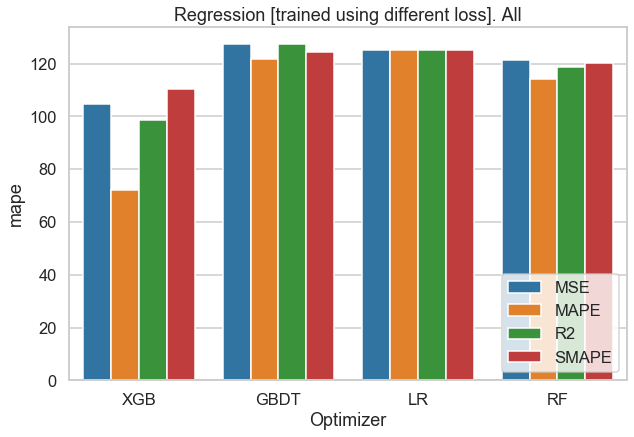

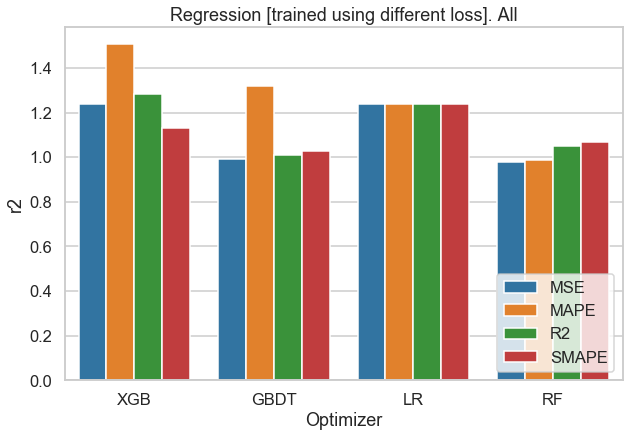

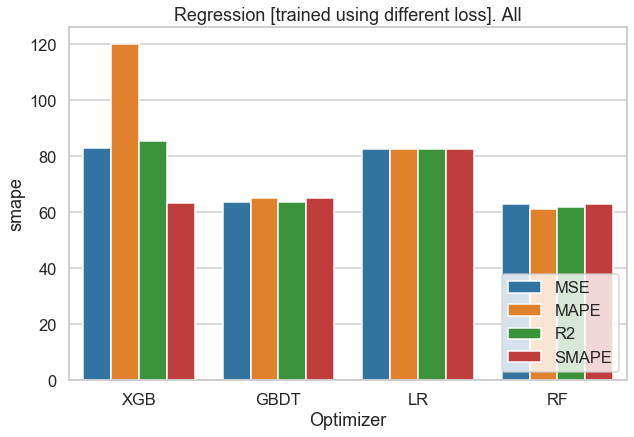

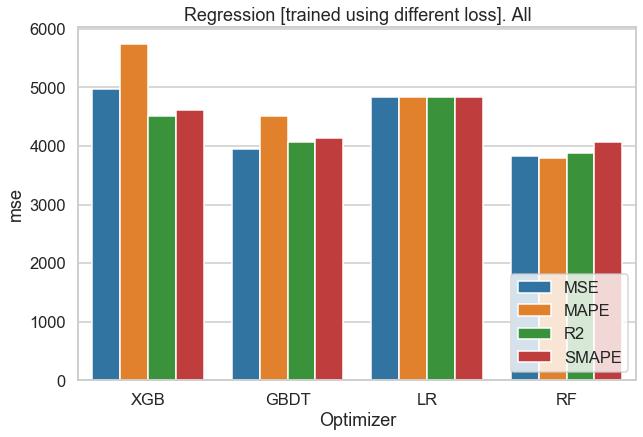

In [53]:
for M in ['mape','r2','smape','mse']:
    
    import seaborn as sns
    sns.set_style("ticks")
    sns.set_style("whitegrid")
    sns.set_context("talk")

    plt.figure(figsize=(10,6.5))
    ax = sns.barplot(x="Optimizer", y=M,hue='Training', data=RES)
    plt.setp(ax.get_legend().get_texts(), fontsize='13')
    plt.legend(loc='lower right')
    plt.title('Regression [trained using different loss]. All')

    plt.show()